In [1]:
import os
from module.object_detection.YOLOv3DataGenerator import YOLOv3DataGenerator

In [2]:
CFG = {
    "dataset_dir":  "D:\Github Public\DATASET MANAGER\ObjectDetection_SIMPLE",
    "image_size": (32*6, 32*5),
    "anchor": 3,
    "batch": 3,
    "annotation_dict": {"Face": 0,"Oppai": 1}, 
}

In [3]:
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [path for path in path_list if "_ROI" not in path]
path_list = [path for path in path_list if ".csv" not in path]
path_list = [(path_list[i], path_list[i+1]) for i in range (0,len(path_list),2)]

In [4]:
data_generator = YOLOv3DataGenerator(
    input=path_list,
    annotation_dict=CFG["annotation_dict"],
    image_size=CFG["image_size"], 
    num_anchor=CFG["anchor"], 
    horizontal_flip=False, 
    vertical_flip=False, 
    translate_range=None, 
    rotation_range=None,
)

dataset = data_generator.generate_dataset(
    batch_size=CFG["batch"],
    drop_reminder=False,
)

Calculating anchor size ... 3 anchor boxes: [(0.62, 0.62), (0.43, 0.43), (0.5, 0.5)]
CALLING preprocessing function
READ IMAGE ... COMPLETE
READ XML ... COMPLETE
AUGMENTATION: padding -> COMPLETE
Generate annotation labels ... COMPLETE


In [5]:
dataset

<PrefetchDataset shapes: ((None, 160, 192, None), ((None, 5, 6, 3, 7), (None, 10, 12, 3, 7), (None, 20, 24, 3, 7))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

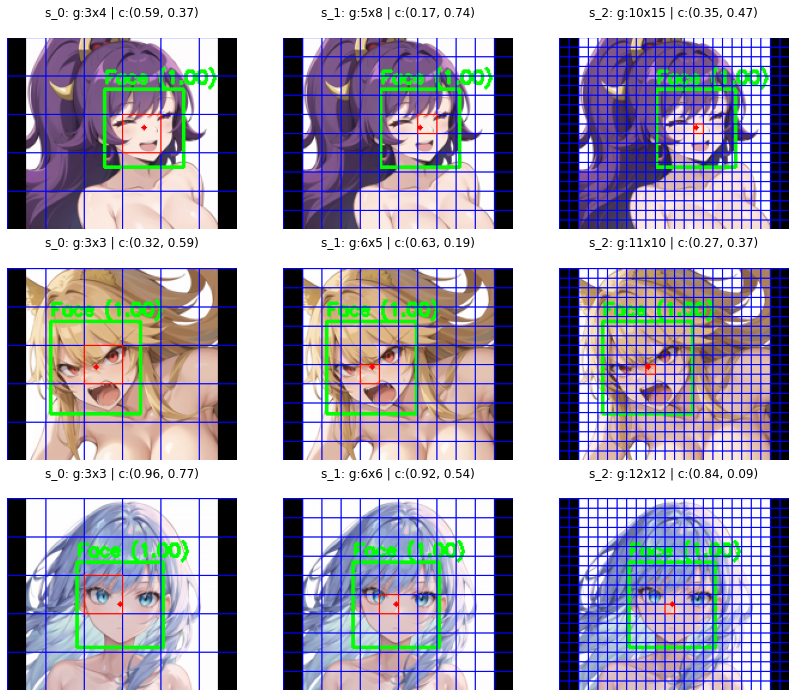

In [6]:
from module.object_detection.YOLOv3Visualizer import YOLOv3Visualizer
class_map = {}

for key, value in CFG["annotation_dict"].items():
    class_map[value] = key

def calculate_figsize(image_width, image_height, num_row, num_col, percentage=40):
    fig_width = int(image_width * num_col / percentage)
    fig_height = int(image_height * num_row / percentage)
    return (fig_width, fig_height)

figsize = calculate_figsize(CFG["image_size"][0], CFG["image_size"][1], CFG["batch"], 3)
visualizer = YOLOv3Visualizer(class_map)
visualizer.display_batch(dataset, figsize=figsize, show_grid=True, show_highlight=True)

In [7]:
from model.YOLOv3 import YOLOv3

model = YOLOv3(CFG["image_size"], num_anchor=CFG["anchor"], num_classes=len(CFG["annotation_dict"]))
model.model.input.shape, model.model.output[0].shape, model.model.output[1].shape, model.model.output[2].shape

(TensorShape([None, 160, 192, 3]),
 TensorShape([None, 5, 6, 3, 7]),
 TensorShape([None, 10, 12, 3, 7]),
 TensorShape([None, 20, 24, 3, 7]))

In [8]:
model.compile()
model.train(dataset)

Epoch 1/10
3/3 [==============================] - 20s 873ms/step - loss: 0.4841 - tf.reshape_loss: 0.3983 - tf.reshape_1_loss: 0.0730 - tf.reshape_2_loss: 0.0128 - tf.reshape_accuracy: 0.1635 - tf.reshape_1_accuracy: 0.2873 - tf.reshape_2_accuracy: 0.0581
Epoch 2/10
3/3 [==============================] - 0s 109ms/step - loss: 0.4506 - tf.reshape_loss: 0.3604 - tf.reshape_1_loss: 0.0677 - tf.reshape_2_loss: 0.0225 - tf.reshape_accuracy: 0.1635 - tf.reshape_1_accuracy: 0.2798 - tf.reshape_2_accuracy: 0.0554
Epoch 3/10
3/3 [==============================] - 0s 112ms/step - loss: 0.3855 - tf.reshape_loss: 0.2990 - tf.reshape_1_loss: 0.0734 - tf.reshape_2_loss: 0.0131 - tf.reshape_accuracy: 0.1683 - tf.reshape_1_accuracy: 0.2913 - tf.reshape_2_accuracy: 0.0568
Epoch 4/10
3/3 [==============================] - 0s 112ms/step - loss: 0.3999 - tf.reshape_loss: 0.3085 - tf.reshape_1_loss: 0.0714 - tf.reshape_2_loss: 0.0200 - tf.reshape_accuracy: 0.1587 - tf.reshape_1_accuracy: 0.2849 - tf.reshap